# Introduction to medical statistics
Dr Alan McWilliam

Version 1 - 14th November 2024


---






In this notebook we will work through examples of the most common medical statistics which we introduce in the lecture. We will use R for this practical session. R is an open source scripting language specially designed for statistical analysis. It comes with libraries for data cleaning, survival analysis and classification models, amongst other possibilities.

As this notebook uses R, you will first need to change the runtime type to 'R', in the 'Runtime' drop down menu above, select 'change runtime type'. In the pop-up box, in the drop down list, choose R.



---

### 1. Set-up libraries
First, we need one additional library which isn't available automatically within google colab. This will be used to plot the survival curves.

(This may take a couple minutes...)

In [63]:
install.packages('survminer')



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘markdown’, ‘png’, ‘jpeg’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘polynom’, ‘rstatix’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘gridtext’, ‘ggpubr’, ‘gridExtra’, ‘maxstat’, ‘survMisc’, ‘ggtext’




Now we will call the libraries needed for the script.

In [64]:
library('survival')
library('ggplot2')
library('survminer')
library('dplyr')

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma






---
### 2. Explore the data
The library 'survival' contains example datasets which we can use to start setting up a survival analysis. Let's load the dataset 'lung', this contains demographic and clinical data from individuals with advanced lung cancer.

First, let's load in the dataset into a varianble called 'lung_data'

In [66]:
lung_data <- lung


Let's have a look at what is inside the data we have read and start to understand what the data looks like. There will be 10 variables:

1.   nst: Institution code
2.   time: Survival time in days
3.   status: censoring status 1=censored, 2=dead
4.   age: Age in years
5.   sex: Male=1 Female=2
6.   ph.ecog: ECOG performance score as rated by the physician. 0=asymptomatic, 1= symptomatic but completely ambulatory, 2= in bed <50% of the day, 3= in bed > 50% of the day but not bedbound, 4 = bedbound
7.   ph.karno: Karnofsky performance score (bad=0-good=100) rated by physician
8.   pat.karno: Karnofsky performance score (0 = bad, 100 = good) as rated by patient
9.   meal.cal: Calories consumed at meals
10.  wt.loss: Weight loss in last six months


The function **'head'** will print out the first few rows of the dataframe, **'nrow'** will tell us how many rows (i.e., patients) we have available.

In [67]:
head(lung_data)
nrow(lung_data)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,306,2,74,1,1,90,100,1175,NA
2,3,455,2,68,1,0,90,90,1225,15
3,3,1010,1,56,1,0,90,90,NA,15
4,5,210,2,57,1,1,90,60,1150,11
5,1,883,2,60,1,0,100,90,NA,0
6,12,1022,1,74,1,1,50,80,513,0


[1] 228

The first thing to do with any dataframe is to start to understand what the dataframe contains and what the data looks like. R has many built in functions to do this with, but we also need to ensure that the data is being handled correctly. For example, does R know if the variables are continuous variables or catagorical?

Let's start by generating a **'summary'** of the dataframe and look to see if the output makes sense.

In [68]:
summary(lung_data)



      inst            time            status           age       
 Min.   : 1.00   Min.   :   5.0   Min.   :1.000   Min.   :39.00  
 1st Qu.: 3.00   1st Qu.: 166.8   1st Qu.:1.000   1st Qu.:56.00  
 Median :11.00   Median : 255.5   Median :2.000   Median :63.00  
 Mean   :11.09   Mean   : 305.2   Mean   :1.724   Mean   :62.45  
 3rd Qu.:16.00   3rd Qu.: 396.5   3rd Qu.:2.000   3rd Qu.:69.00  
 Max.   :33.00   Max.   :1022.0   Max.   :2.000   Max.   :82.00  
 NA's   :1                                                       
      sex           ph.ecog          ph.karno        pat.karno     
 Min.   :1.000   Min.   :0.0000   Min.   : 50.00   Min.   : 30.00  
 1st Qu.:1.000   1st Qu.:0.0000   1st Qu.: 75.00   1st Qu.: 70.00  
 Median :1.000   Median :1.0000   Median : 80.00   Median : 80.00  
 Mean   :1.395   Mean   :0.9515   Mean   : 81.94   Mean   : 79.96  
 3rd Qu.:2.000   3rd Qu.:1.0000   3rd Qu.: 90.00   3rd Qu.: 90.00  
 Max.   :2.000   Max.   :3.0000   Max.   :100.00   Max.   :100.0

Look at the summary statistics. For each we ahve a mean and medium, quartiles, max and min. This is fine for continuous variables but not appropriate for a catagorical variable. For example, sex is 1 for males and 2 for females, here we need a count for each catagory not a mean or medium. Let's update the variable list by changing the type and re-run the summary stats.

In [69]:
lung_data$status <- factor(lung_data$status)
lung_data$sex <- factor(lung_data$sex)
lung_data$ph.ecog <- factor(lung_data$ph.ecog)
lung_data$ph.karno <- factor(lung_data$ph.karno)
lung_data$pat.karno <- factor(lung_data$pat.karno)

summary(lung_data)

      inst            time        status       age        sex     ph.ecog   
 Min.   : 1.00   Min.   :   5.0   1: 63   Min.   :39.00   1:138   0   : 63  
 1st Qu.: 3.00   1st Qu.: 166.8   2:165   1st Qu.:56.00   2: 90   1   :113  
 Median :11.00   Median : 255.5           Median :63.00           2   : 50  
 Mean   :11.09   Mean   : 305.2           Mean   :62.45           3   :  1  
 3rd Qu.:16.00   3rd Qu.: 396.5           3rd Qu.:69.00           NA's:  1  
 Max.   :33.00   Max.   :1022.0           Max.   :82.00                     
 NA's   :1                                                                  
 ph.karno    pat.karno     meal.cal         wt.loss       
 50  : 6   90     :60   Min.   :  96.0   Min.   :-24.000  
 60  :19   80     :51   1st Qu.: 635.0   1st Qu.:  0.000  
 70  :32   70     :41   Median : 975.0   Median :  7.000  
 80  :67   100    :35   Mean   : 928.8   Mean   :  9.832  
 90  :74   60     :30   3rd Qu.:1150.0   3rd Qu.: 15.750  
 100 :29   (Other): 8   Max.  

Does this now make more sense?


### 2a. Visualising data
It can also be helpful to start making some plots to look at what the data looks like. The form of plot will depend on the type and shape of the data. The main options being, histograms, box + whisker, violin plots.

You can also use plots to visualise differences between categories. For example in this data, do males or females have greater weight loss?

Let's make some plots and see what we can do...

Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_bin()`).”


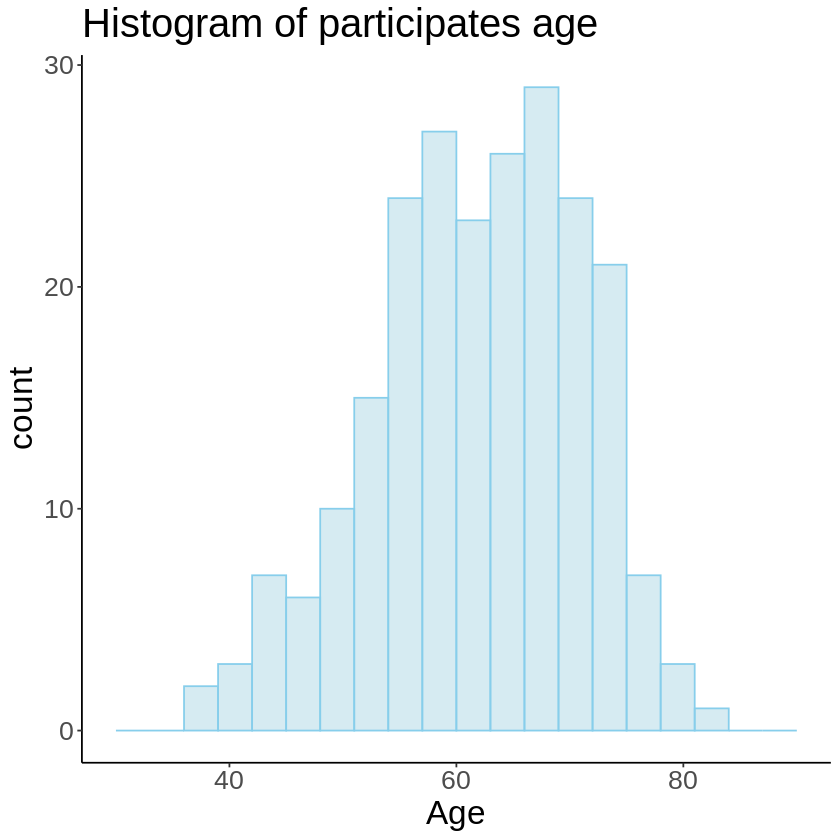

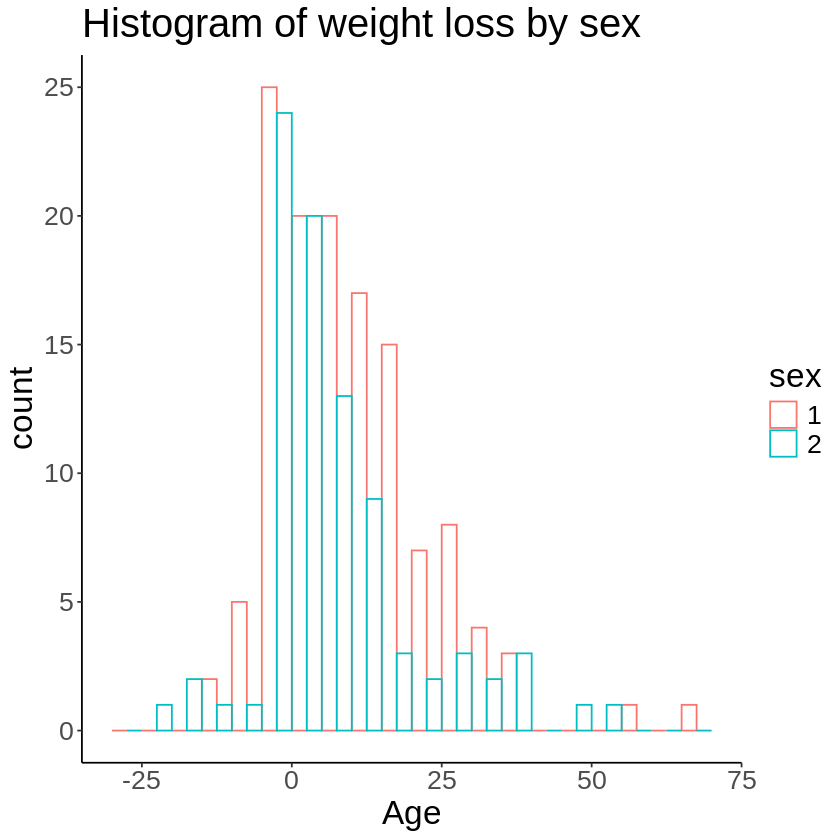

In [71]:
# Plot a histogram of participants age in the study
ggplot(data=lung_data, aes(age)) +
  geom_histogram(breaks=seq(30,90, by = 3),
                 col = "skyblue", fill = "lightblue", alpha = 0.5) +
  labs(title = 'Histogram of participates age', x = "Age" ) +
  theme_classic() +
  theme(text = element_text(size = 20))

# Plot histogram of the participants weight loss, split on sex
ggplot(data=lung_data, aes(x = wt.loss, color = sex)) +
  geom_histogram(breaks=seq(-30,70, by = 5), fill="white", position="dodge", alpha = 0.5) +
  labs(title = 'Histogram of weight loss by sex', x = "Age" ) +
  theme_classic() +
  theme(text = element_text(size = 20))


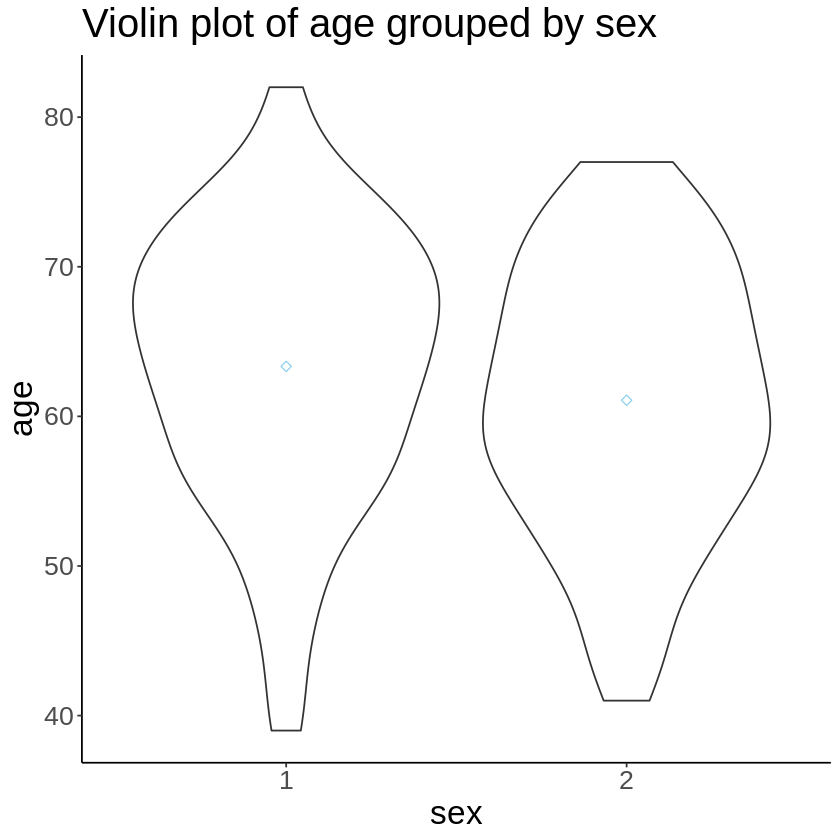

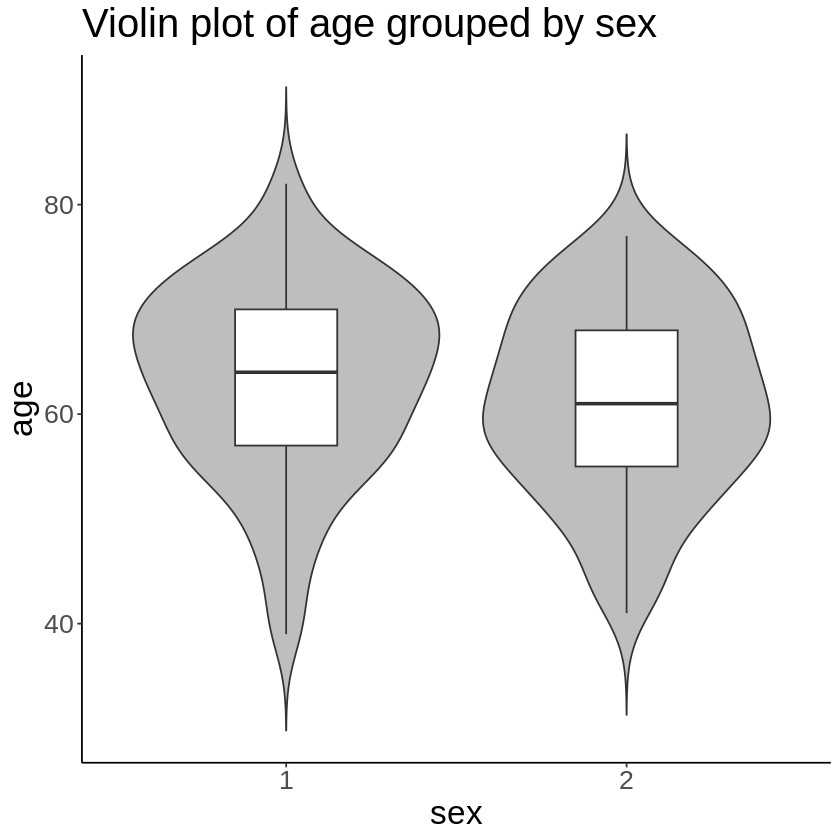

In [72]:

# Violin plots show us the shape of the data and have many variations, here we will plot the distribution of age grouped on sex
ggplot(lung_data, aes(x=sex, y=age)) +
  geom_violin() +
  stat_summary(fun.y=mean, geom="point", shape=23, size=2, color = 'skyblue') +
  labs(title = 'Violin plot of age grouped by sex') +
  theme_classic() +
  theme(text = element_text(size = 20))

ggplot(lung_data, aes(x=sex, y=age)) +
  geom_violin(trim=FALSE, fill="gray") +
  geom_boxplot(width=0.3) +
  labs(title = 'Violin plot of age grouped by sex') +
  theme_classic() +
  theme(text = element_text(size = 20))



Warning message:
“Removed 57 rows containing missing values or values outside the scale range
(`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 57 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 57 rows containing missing values or values outside the scale range
(`geom_point()`).”


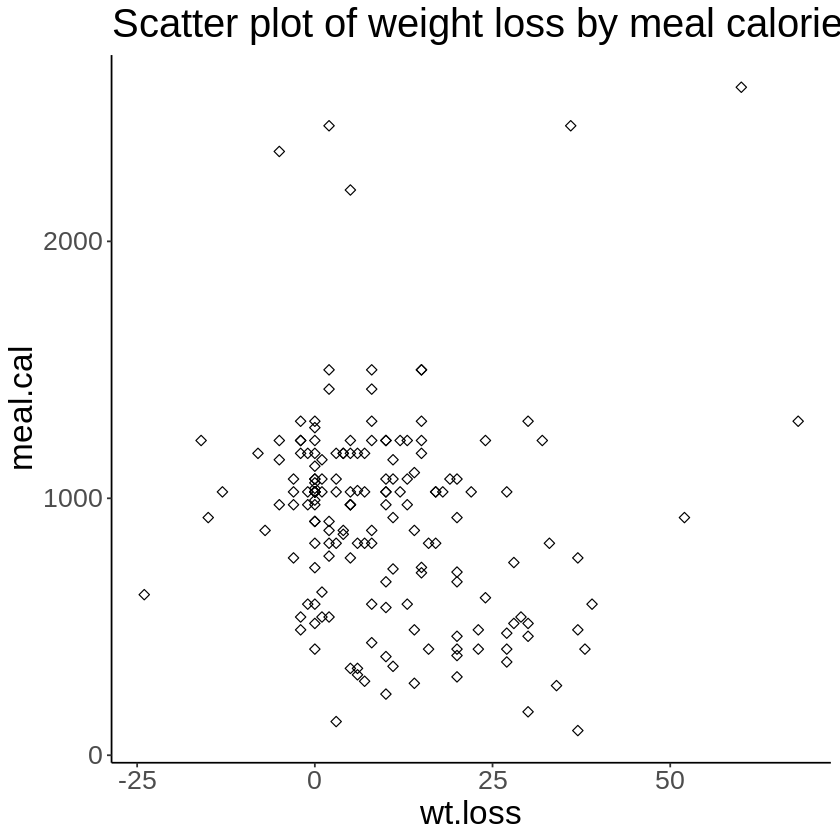

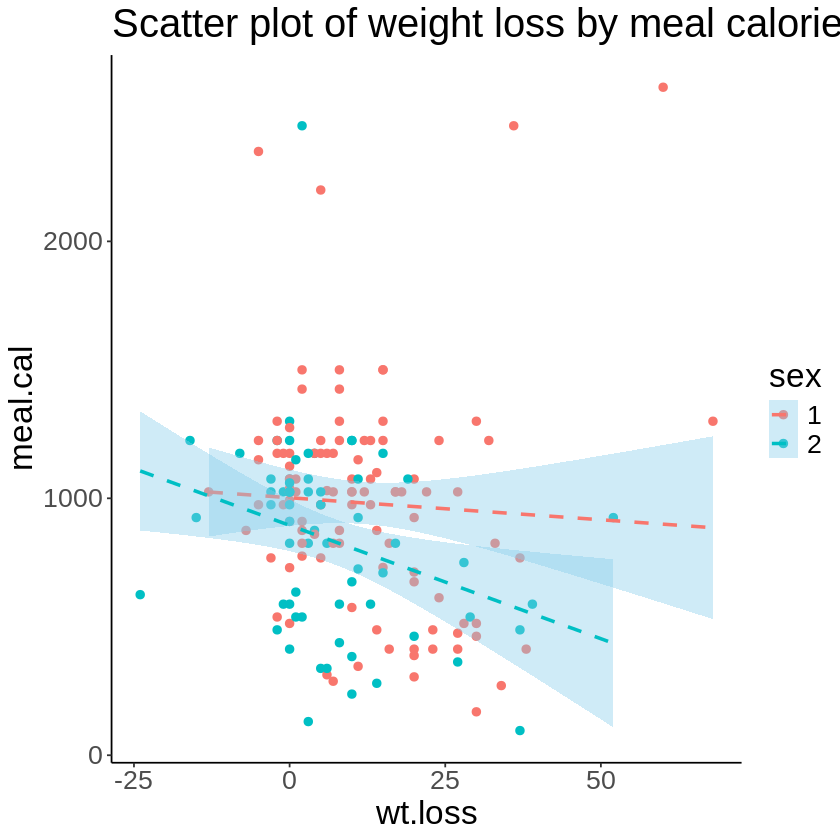

In [73]:
# scatter plot of weight loss by calories
ggplot(lung_data, aes(x=wt.loss, y=meal.cal)) +
  geom_point(size=2, shape=23) +
  labs(title = 'Scatter plot of weight loss by meal calories') +
  theme_classic() +
  theme(text = element_text(size = 20))

# Adding linear fit to the scatter plot and grouping by sex to visualise differences between men and women
ggplot(lung_data, aes(x=wt.loss, y=meal.cal, color=sex)) +
  geom_point(size=2, shape=19) +
  geom_smooth(method=lm, linetype="dashed", fill='skyblue') +
  labs(title = 'Scatter plot of weight loss by meal calories') +
  theme_classic() +
  theme(text = element_text(size = 20))


### 2b. Understanding the data
We can also explore summary statistics and identify significant differences between groups.

Consider the use of parametric tests (assume normality in the data) and non-parametric test (do not assume normality in the data). To test for normality you can use the **shapiro.test**, this compares the distribution to a normal distribution, a p>0.05 shows there is no significant difference from a normal distribution and parametric tests could be used.

For example - testing age in the cell below.


In [74]:
shapiro.test(lung_data$age)


	Shapiro-Wilk normality test

data:  lung_data$age
W = 0.98173, p-value = 0.004829


**Some common examples to get started, this list is not exhaustive!**

Examples for continuous variables:
*   students t-test for parametric data
*   Wilcoxon signed-rank test for non-parametric data

Testing against a catagorical variable could be done with an ANOVA

Correlations between variables can also be investiagated using:
*   Pearson
*   Spearman (non parameteric, ranks a monotonic relationship)





In [75]:
# Some examples of the tests described above

t.test(age ~ sex, data = lung_data)
wilcox.test(age ~ sex, data = lung_data)

wilcox.test(wt.loss ~ sex, data = lung_data)



	Welch Two Sample t-test

data:  age by sex
t = 1.8632, df = 194.72, p-value = 0.06394
alternative hypothesis: true difference in means between group 1 and group 2 is not equal to 0
95 percent confidence interval:
 -0.1324347  4.6580386
sample estimates:
mean in group 1 mean in group 2 
       63.34058        61.07778 



	Wilcoxon rank sum test with continuity correction

data:  age by sex
W = 7136.5, p-value = 0.05701
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  wt.loss by sex
W = 6472.5, p-value = 0.02889
alternative hypothesis: true location shift is not equal to 0


We can see there is no significant difference in age between male and females in the dataset.
We can, however, see a significant difference in weight loss. To get a fuller picture, we can use the next cell to provide a summary of the weight loss for males (sex = 1) and females (sex = 2), showing that males (in general) lose significantly more weight.


In [76]:
tapply(lung_data$wt.loss, lung_data$sex, summary)

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -13.00    0.75    8.00   11.22   18.50   68.00      10 

$`2`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-24.000   0.000   4.000   7.767  11.000  52.000       4 


Testing catagorical data using an ANOVA test, this allows us to compare means in a situation where there are more than two groups. Here, using the multiple groups in the ECOG performance status.

In [77]:
# Clean the data to remove the NA's in the performance status
# We will also remove the performance status 3 patient as there is only one with this value which will not result in any statistical power

lung_data <- lung_data %>%
  filter(ph.ecog %in% c(0,1,2))

summary(factor(lung_data$ph.ecog))

test_aov <- aov(wt.loss ~ ph.ecog, data = lung_data)
summary(test_aov)

0   1   2 
 63 113  50

             Df Sum Sq Mean Sq F value Pr(>F)  
ph.ecog       2   1275   637.7   3.819 0.0235 *
Residuals   209  34901   167.0                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
14 observations deleted due to missingness

So, in the above test, we can see that there is a significant in the groups, but we don't know between which groups (or indeed, possibly, between all groups). To check where we see significance we can use a Tukey test to comapre the means between all groups.   

In [78]:
TukeyHSD(test_aov)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = wt.loss ~ ph.ecog, data = lung_data)

$ph.ecog
        diff        lwr       upr     p adj
1-0 4.594340 -0.3079060  9.496585 0.0714390
2-0 6.511111  0.5168392 12.505383 0.0296097
2-1 1.916771 -3.5105302  7.344073 0.6825490


From the box above, we can see there is a significance difference in weight loss between patients with ECOG performance status 0 and 2.

Finally, we will look at how to stest for correlations between variables.

In [79]:
cor.test(lung_data$meal.cal, lung_data$wt.loss, method = "pearson")
cor.test(lung_data$meal.cal, lung_data$wt.loss, method = "spearman")


	Pearson's product-moment correlation

data:  lung_data$meal.cal and lung_data$wt.loss
t = -1.4654, df = 167, p-value = 0.1447
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.25922785  0.03894525
sample estimates:
       cor 
-0.1126772 


Warning message in cor.test.default(lung_data$meal.cal, lung_data$wt.loss, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  lung_data$meal.cal and lung_data$wt.loss
S = 1015046, p-value = 0.0005852
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2618046 


So, no correlation between weight loss and meal calories in this example and the correlation coefficients are also very low. If you remember the scatter plot from above then this is not an unexpected result!




---
### 3. Survial analysis

Now, let's start building a survival function and plot our first survival graph. First, we will use the function **survfit** to create a survival function, we can also call this to provide summary statistics for the population.

(The survival function expects events to be 0 (no event) or 1 (event), the first lines of code changes the cataogories to work with the function.)

In [80]:
#cleaning the data so teh survival event entries are as epected by the Surv function

lung_data_surv <- lung_data %>%
  mutate(status = case_when(status == 2 ~ 1,
                            status == 1 ~ 0))




First, let's look at the survival curve for the full cohort. In the survival function below, we denote this using the **~1**.

Printing the function (**s1**) will provide median survival times for the cohort, and if we specify groups, for each group in turn.


In [81]:
s1 <- survfit(Surv(time, status) ~ 1, data = lung_data_surv)
s1


Call: survfit(formula = Surv(time, status) ~ 1, data = lung_data_surv)

       n events median 0.95LCL 0.95UCL
[1,] 226    163    310     285     363

Now we have the **survfit** function, we can plot our first Kaplan Meier curve.

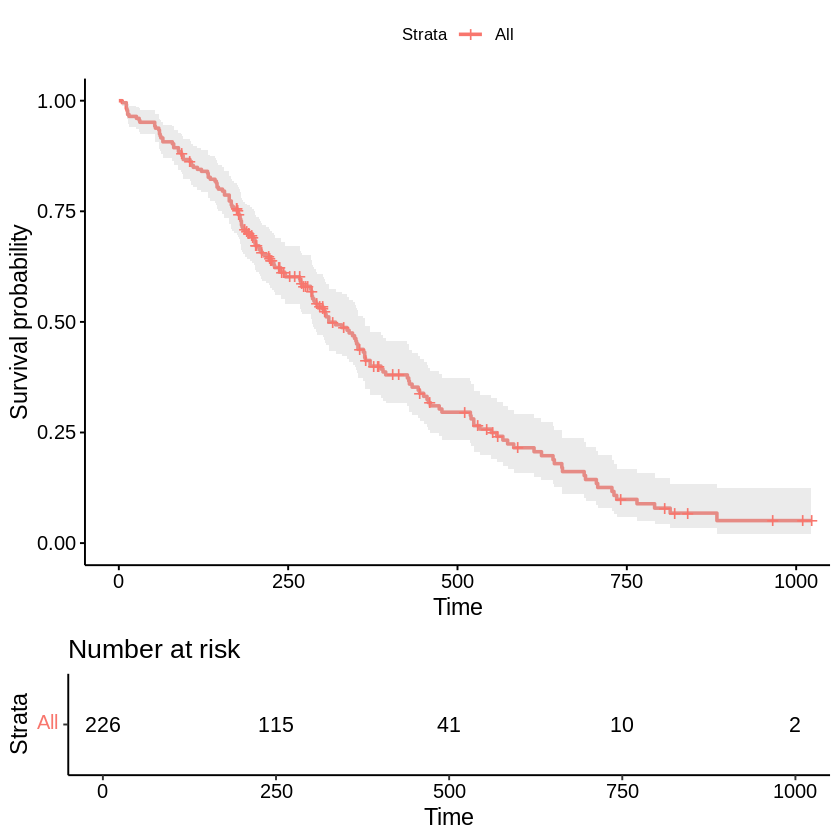

In [82]:
ggsurvplot(s1, risk.table = TRUE, conf.int = TRUE, ncensor.plot = FALSE)



Now, let's look to see if men and women have different survival times.

In [83]:
s2 <- survfit(Surv(time, status) ~ sex, data = lung_data_surv)
s2

Call: survfit(formula = Surv(time, status) ~ sex, data = lung_data_surv)

        n events median 0.95LCL 0.95UCL
sex=1 136    110    283     218     320
sex=2  90     53    426     348     550

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


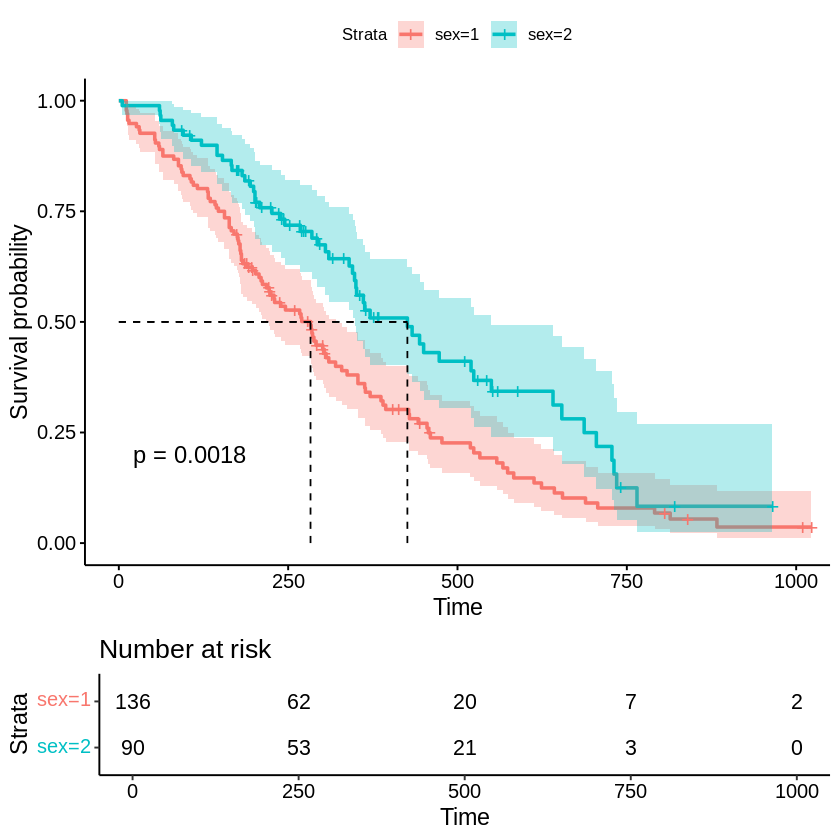

In [84]:
ggsurvplot(s2, risk.table = TRUE, conf.int = TRUE, surv.median.line = "hv", pval = TRUE,ncensor.plot = FALSE)


We can create different groups to test for survival differences, but be careful you don't start to p-hack....


[1] "Median calorie intake in population is 975"


Call: survfit(formula = Surv(time, status) ~ cal_split, data = lung_data_surv)

   47 observations deleted due to missingness 
                 n events median 0.95LCL 0.95UCL
cal_split=FALSE 91     65    303     245     371
cal_split=TRUE  88     67    337     269     428

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
“All aesthetics have length 1, but the data has 2 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


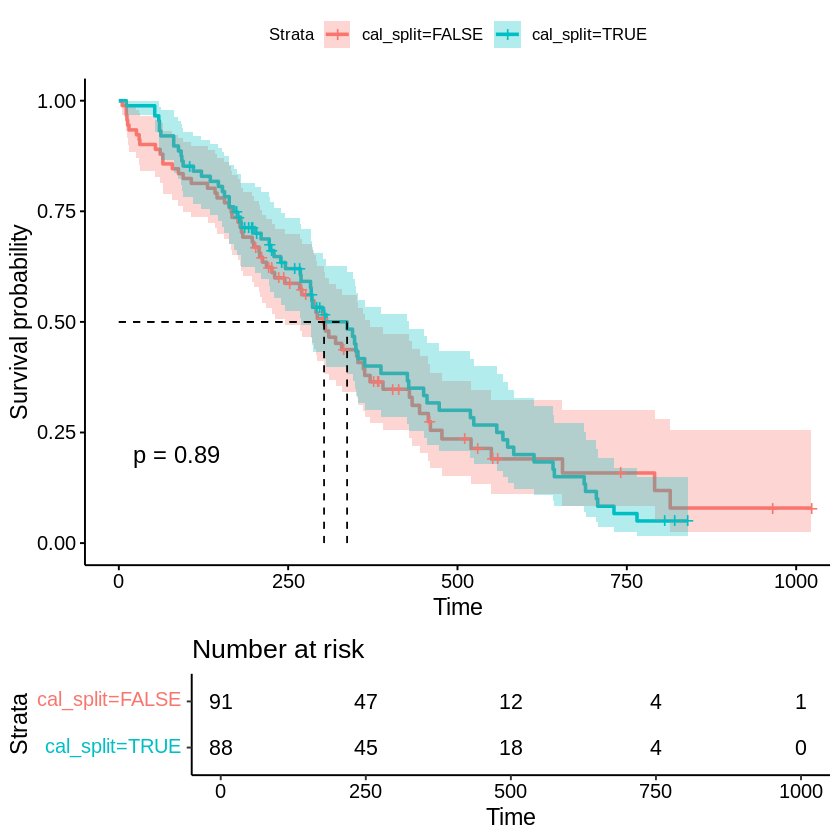

In [120]:
print(paste('Median calorie intake in population is', median(lung_data_surv$meal.cal, na.rm = TRUE), sep = ' '))

lung_data_surv$cal_split <- lung_data_surv$meal.cal > median(lung_data_surv$meal.cal, na.rm = TRUE)
#lung_data_surv$cal_split <- lung_data_surv$meal.cal > 398   ### this is me trying to p-hack!!!!

s3 <- survfit(Surv(time, status) ~ cal_split, data = lung_data_surv)
s3
ggsurvplot(s3, risk.table = TRUE, conf.int = TRUE, surv.median.line = "hv", pval = TRUE,ncensor.plot = FALSE)






---

### 4. Cox proportional hazards model
In this section we will start to build up a cox model to investigate univariable and multivariable models for survival.

First, let's build a uni- (one) variable cox model.


In [123]:
univariable_cox <- coxph(Surv(time, status) ~ sex, data = lung_data_surv)

summary(univariable_cox)

Call:
coxph(formula = Surv(time, status) ~ sex, data = lung_data_surv)

  n= 226, number of events= 163 

        coef exp(coef) se(coef)      z Pr(>|z|)   
sex2 -0.5169    0.5964   0.1677 -3.083  0.00205 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     exp(coef) exp(-coef) lower .95 upper .95
sex2    0.5964      1.677    0.4293    0.8284

Concordance= 0.577  (se = 0.021 )
Likelihood ratio test= 9.99  on 1 df,   p=0.002
Wald test            = 9.5  on 1 df,   p=0.002
Score (logrank) test = 9.72  on 1 df,   p=0.002


If you remember from the lecture, the exp(coef) will give us the **hazard ratio** for the variable. The confidence intervals are also presented for the hazard ratio in the second row above.

In this case, age is significantly associated with survival. The hazard ratio is 0.6, which indicated the risk of death is decreasing as an individual becomes older.

The format for a multivariable model is the same, we just add any additional variables of interest after the **~** using a **+** between variables.

In [124]:
multivariable_cox <- coxph(Surv(time, status) ~ sex + age + ph.ecog + wt.loss, data = lung_data_surv)

summary(multivariable_cox)

Call:
coxph(formula = Surv(time, status) ~ sex + age + ph.ecog + wt.loss, 
    data = lung_data_surv)

  n= 212, number of events= 150 
   (14 observations deleted due to missingness)

              coef exp(coef)  se(coef)      z Pr(>|z|)    
sex2     -0.582459  0.558523  0.175942 -3.311 0.000931 ***
age       0.013071  1.013157  0.009674  1.351 0.176650    
ph.ecog1  0.459257  1.582897  0.208275  2.205 0.027450 *  
ph.ecog2  1.003269  2.727183  0.252834  3.968 7.25e-05 ***
ph.ecog3        NA        NA  0.000000     NA       NA    
wt.loss  -0.009060  0.990981  0.006701 -1.352 0.176323    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         exp(coef) exp(-coef) lower .95 upper .95
sex2        0.5585     1.7904    0.3956    0.7885
age         1.0132     0.9870    0.9941    1.0326
ph.ecog1    1.5829     0.6318    1.0524    2.3809
ph.ecog2    2.7272     0.3667    1.6615    4.4764
ph.ecog3        NA         NA        NA        NA
wt.loss     0.9910     1.0091    0

In the above table, look to see how continuous variables (age and weight loss) and catagorical variables (sex and ECOG performance status) are handled. For a catogorical variable, each catagory in turn is compared to the refernce catagory, default is the first. i.e., each ECOG is compared against ECOG = 0.


We can also present a visualisation of the hazard ratios, these figures are called forest plots. This will plot the hazard ratios, with the confidence interval shown. If the confidence intervals includes the value 1, this visually indicates this variable does not have a significance association with the outcome.


Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


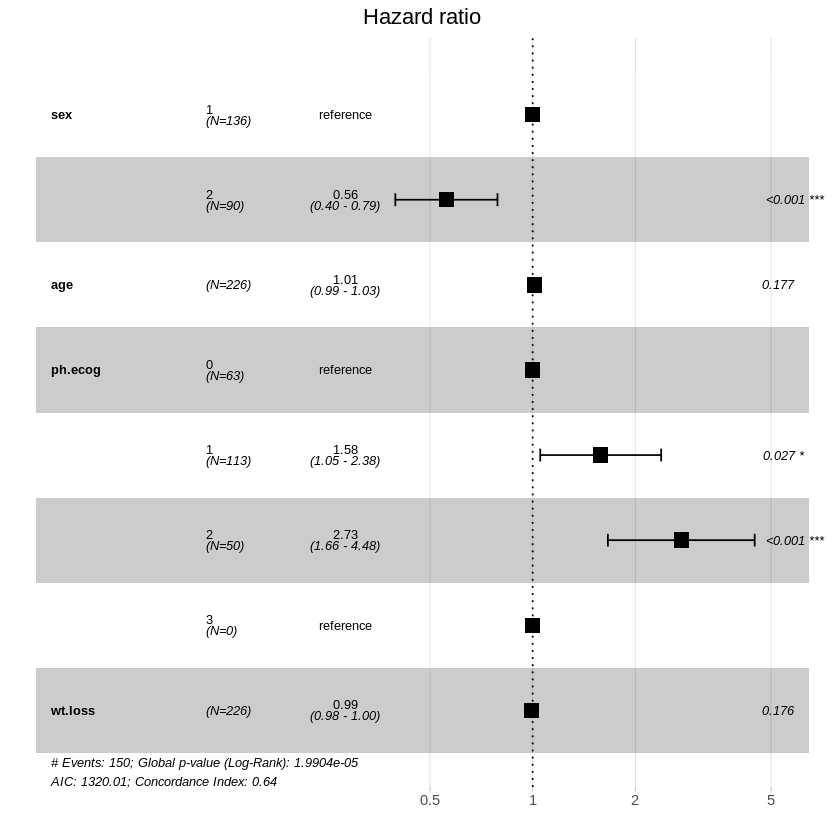

In [125]:
ggforest(multivariable_cox)


---
### 4. Odds ratios

In this final section we will have a look at Odds ratios. As we discussed, the main difference between Odds ratios and the Cox proportional hazards models is that the Odds ratio does not handle time to an event.

Here, we will use the **status** variable as our event, **i.e., we don't care when the event happen, just that is has happend.** From our dataset, we will
set our exposure as being female and calculate the odd ratio for death of being female compared to being male.

In [166]:
## Method 1 - very manual
## First we will extract the data into a matrix, showing us how many events are in each group

event_count_female <- lung_data_surv %>%
  filter(sex == 2) %>%
  group_by(status) %>%
  summarise(n = n())

event_count_male <- lung_data_surv %>%
  filter(sex == 1) %>%
  group_by(status) %>%
  summarise(n = n())

event_count <- event_count_female
event_count$tmp <- event_count_male[,2]

colnames(event_count) <- c('event', 'female', 'male')
event_count <- t(event_count)
event_count

event,0,1
female,37,53
male,26,110


In [170]:
## Now let's calculate the odds of an event for each group
## want event yes / event no

odds_female = event_count[2,2] / event_count[2,1]
odds_male = event_count[3,2] / event_count[3,1]

odds_female
odds_male



female 
1.432432

male 
4.230769

In [171]:
## And calculated the odds ratio
odds_ratio = odds_female / odds_male
odds_ratio

female 
0.3385749

So, female participants in the cohort are 0.34 times less likely of risk of death in the study than males.

Let's try something simpler. We can use a linear model to calculate the odds ratio in two steps. Like above for the cox proportional hazards model, is we take the exponential of the coefficient(s) from the linear model we calculate the odds ratio.

Let's try...

In [172]:
linear_model <- glm(status ~ sex, family = "binomial", data = lung_data_surv)
summary(linear_model)

exp(coefficients(linear_model))




Call:
glm(formula = status ~ sex, family = "binomial", data = lung_data_surv)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.4424     0.2181   6.614 3.73e-11 ***
sex2         -1.0830     0.3057  -3.543 0.000396 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 267.48  on 225  degrees of freedom
Residual deviance: 254.62  on 224  degrees of freedom
AIC: 258.62

Number of Fisher Scoring iterations: 4


(Intercept)        sex2 
  4.2307692   0.3385749

So, for sex2 (i.e., female) the odds ratio is 0.34, same answer as above working manually!

The nice thing about the linear model is it can allow for multivariable models too.


---

